Import Necessary Libraries

In [174]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

Load and Display the Original Image

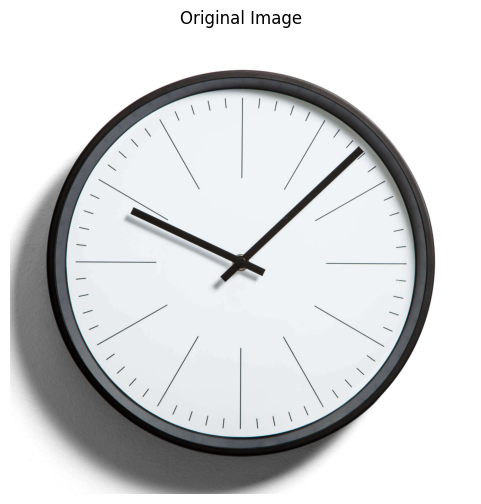

In [175]:
# Load the image
img = cv2.imread('./data/minimal.jpg')

# Check if the image was loaded
if img is not None:
    # Convert BGR to RGB for displaying correctly with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the original image
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
else:
    print("Image not found. Please check the path and filename.")


 Preprocess the Image

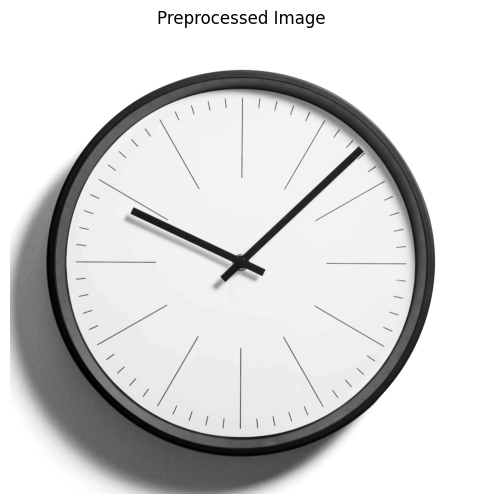

In [176]:
# Make a copy of the image to avoid modifying the original
processed = img.copy()

# Convert to grayscale
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)

# Apply median blur to reduce noise
processed = cv2.medianBlur(processed, 5)

# Display the preprocessed image
plt.figure(figsize=(6,6))
plt.imshow(processed, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()


Apply Canny Edge Detection

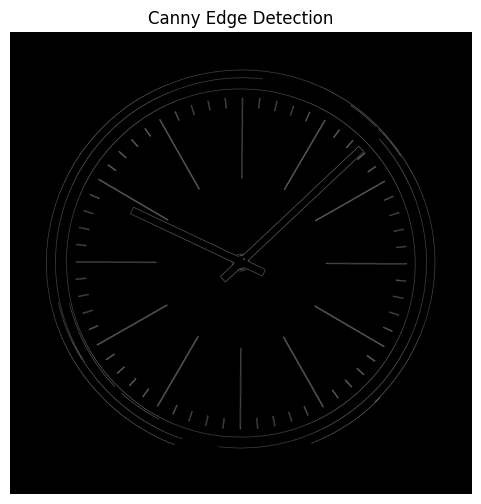

In [177]:
# Apply Canny edge detection
canny = cv2.Canny(processed, 100, 200)

# Display the edges detected by Canny
plt.figure(figsize=(6,6))
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()


Detect Lines Using Hough Transform

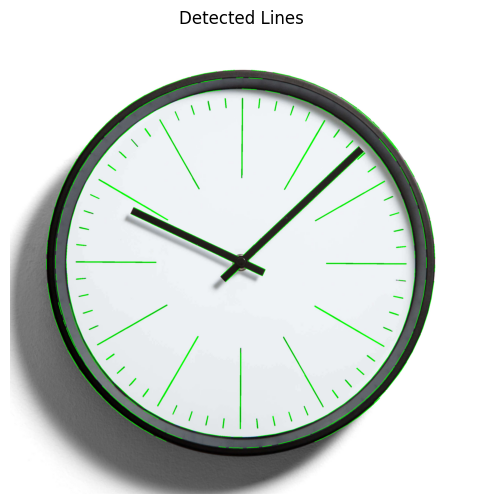

In [178]:
# Adjusted parameters for Hough Line Transform
threshold = 30
deg_resolution = np.pi / 180
rad_resolution = 1
min_length = 30
max_line_gap = 5

# Detect lines using HoughLinesP with adjusted parameters
lines = cv2.HoughLinesP(
    canny,
    rho=rad_resolution,
    theta=deg_resolution,
    threshold=threshold,
    minLineLength=min_length,
    maxLineGap=max_line_gap,
)

# Create a copy of the original image to draw lines
img_with_lines = img.copy()

# Check if any lines are detected
if lines is not None:
    # Draw the detected lines on the image
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Convert BGR to RGB for displaying
    img_with_lines_rgb = cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB)
    
    # Display the image with detected lines
    plt.figure(figsize=(6,6))
    plt.imshow(img_with_lines_rgb)
    plt.title('Detected Lines')
    plt.axis('off')
    plt.show()
else:
    print("No lines were detected.")


Identify Lines Near the Center of the Clock

In [179]:
# Calculate the center of the image
cx = img.shape[1] / 2  # Width divided by 2
cy = img.shape[0] / 2  # Height divided by 2
radius = max(img.shape[0], img.shape[1]) * 0.1  # 10% of the maximum dimension

print(f"Center coordinates: ({cx}, {cy}), Radius: {radius}")

# Function to calculate Euclidean distance
def dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Function to determine if a line is near the center
def line_near_center(x1, y1, x2, y2, cx, cy, radius):
    return dist(x1, y1, cx, cy) <= radius or dist(x2, y2, cx, cy) <= radius

# Initialize a list to hold hand lines (angle, length)
hand_lines = []

# Check if any lines were detected
if lines is not None:
    # Iterate through each line
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Check if the line is near the center
            if line_near_center(x1, y1, x2, y2, cx, cy, radius):
                # Ensure the first point is closer to the center
                if dist(x1, y1, cx, cy) > dist(x2, y2, cx, cy):
                    x1, y1, x2, y2 = x2, y2, x1, y1
                
                # Calculate the angle of the line
                angle = math.degrees(math.atan2(y1 - y2, x2 - x1))
                if angle < 0:
                    angle += 360
                length = dist(x1, y1, x2, y2)
                
                # Append the angle and length to hand_lines
                hand_lines.append((angle, length))
                
                # Debugging statements
                print(f"\nLine from ({x1}, {y1}) to ({x2}, {y2})")
                print(f"Distance to center from point 1: {dist(x1, y1, cx, cy):.2f}")
                print(f"Distance to center from point 2: {dist(x2, y2, cx, cy):.2f}")
                print(f"Angle: {angle:.2f}°, Length: {length:.2f}px")
else:
    print("No lines were detected to find hand lines.")

# Display the hand lines detected
if hand_lines:
    print("\nHand Lines Detected (Angle, Length):")
    for angle, length in hand_lines:
        print(f"Angle: {angle:.2f}°, Length: {length:.2f}px")
else:
    print("No hand lines were detected near the center.")


Center coordinates: (1250.0, 1250.0), Radius: 250.0

Line from (1396, 1080) to (1602, 887)
Distance to center from point 1: 224.09
Distance to center from point 2: 505.64
Angle: 43.13°, Length: 282.29px

Line from (1357, 1171) to (1534, 1005)
Distance to center from point 1: 133.00
Distance to center from point 2: 375.07
Angle: 43.16°, Length: 242.66px

Line from (1084, 1187) to (758, 1034)
Distance to center from point 1: 177.55
Distance to center from point 2: 537.33
Angle: 154.86°, Length: 360.12px

Line from (1235, 1214) to (931, 1072)
Distance to center from point 1: 39.00
Distance to center from point 2: 365.30
Angle: 154.96°, Length: 335.53px

Line from (1213, 1252) to (1142, 1319)
Distance to center from point 1: 37.05
Distance to center from point 2: 128.16
Angle: 223.34°, Length: 97.62px

Line from (1243, 1279) to (1166, 1351)
Distance to center from point 1: 29.83
Distance to center from point 2: 131.37
Angle: 223.08°, Length: 105.42px

Line from (1213, 1249) to (1129, 1209)

Visualize the Hand Lines Data

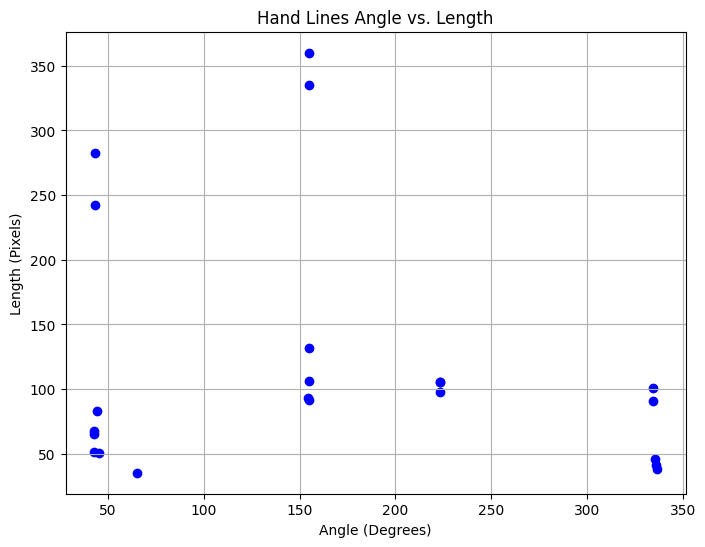

In [180]:
# Check if any hand lines were detected
if hand_lines:
    # Extract angles and lengths
    angles, lengths = zip(*hand_lines)
    
    # Plot the angles vs lengths
    plt.figure(figsize=(8,6))
    plt.scatter(angles, lengths, color='blue')
    plt.xlabel('Angle (Degrees)')
    plt.ylabel('Length (Pixels)')
    plt.title('Hand Lines Angle vs. Length')
    plt.grid(True)
    plt.show()
else:
    print("No hand lines to plot.")


Cluster the Hand Lines by Angle

In [181]:
# Check if any hand lines were detected
if hand_lines:
    # Sort the hand lines by angle
    hand_lines.sort()
    
    # Initialize clusters
    max_angle_gap = 5  # Maximum angle gap to consider in the same cluster
    clusters = [[hand_lines[0]]]
    
    # Cluster the hand lines
    for i in range(1, len(hand_lines)):
        if abs(hand_lines[i][0] - hand_lines[i - 1][0]) <= max_angle_gap:
            clusters[-1].append(hand_lines[i])
        else:
            clusters.append([hand_lines[i]])
    
    # Display the clusters
    print(f"Number of Clusters: {len(clusters)}")
    for idx, cluster in enumerate(clusters):
        print(f"\nCluster {idx + 1}:")
        for angle, length in cluster:
            print(f"Angle: {angle:.2f}°, Length: {length:.2f}px")
else:
    print("No hand lines to cluster.")


Number of Clusters: 5

Cluster 1:
Angle: 42.51°, Length: 65.12px
Angle: 42.61°, Length: 67.94px
Angle: 42.65°, Length: 51.66px
Angle: 43.13°, Length: 282.29px
Angle: 43.16°, Length: 242.66px
Angle: 44.03°, Length: 83.45px
Angle: 45.00°, Length: 50.91px

Cluster 2:
Angle: 64.89°, Length: 35.34px

Cluster 3:
Angle: 154.54°, Length: 93.04px
Angle: 154.80°, Length: 131.52px
Angle: 154.83°, Length: 91.71px
Angle: 154.86°, Length: 360.12px
Angle: 154.89°, Length: 106.02px
Angle: 154.96°, Length: 335.53px

Cluster 4:
Angle: 223.08°, Length: 105.42px
Angle: 223.08°, Length: 105.42px
Angle: 223.34°, Length: 97.62px

Cluster 5:
Angle: 334.56°, Length: 90.80px
Angle: 334.71°, Length: 100.65px
Angle: 335.66°, Length: 46.10px
Angle: 335.90°, Length: 41.63px
Angle: 336.80°, Length: 38.08px


Summarize the Clusters

In [182]:
# Check if any clusters were formed
if hand_lines:
    # Initialize summary list
    summary = []
    
    # Summarize each cluster
    for cluster in clusters:
        angles = np.array([angle for angle, length in cluster])
        lengths = np.array([length for angle, length in cluster])
        
        avg_angle = np.mean(angles)
        max_length = np.max(lengths)
        
        summary.append((max_length, avg_angle))
    
    # Sort the summary by length in descending order
    summary.sort(reverse=True)
    
    # Display the summary
    print("Summary of Clusters (Length, Angle):")
    for length, angle in summary:
        print(f"Length: {length:.2f}px, Angle: {angle:.2f}°")
    
    # Ensure there are at least two hands
    if len(summary) == 1:
        summary.append(summary[0])
else:
    print("No clusters to summarize.")


Summary of Clusters (Length, Angle):
Length: 360.12px, Angle: 154.81°
Length: 282.29px, Angle: 43.30°
Length: 105.42px, Angle: 223.17°
Length: 100.65px, Angle: 335.53°
Length: 35.34px, Angle: 64.89°


Calculate the Time from the Hand Angles

In [183]:
# Check if summary is available
if hand_lines and summary:
    # Assume the longest line is the minute hand and the next is the hour hand
    minute_angle = summary[0][1]
    hour_angle = summary[1][1]
    
    # Calculate the ratios
    hour_ratio = hour_angle / 360.0
    minute_ratio = minute_angle / 360.0
    
    # Calculate hours and minutes
    hours = hour_ratio * 12
    minutes = int(round(minute_ratio * 60)) % 60
    
    # Adjust the hour based on minutes
    if abs(minutes - 60) < 5 or minutes < 5:
        hours = int(round(hours)) % 12
    else:
        hours = int(math.floor(hours)) % 12
    
    if hours == 0:
        hours = 12  # Adjust for 12-hour format
    
    # Display the calculated time
    print(f"The estimated time is {hours}:{minutes:02d}")
else:
    print("Unable to calculate time due to insufficient data.")


The estimated time is 1:26


Visualize the Final Result with Hand Lines

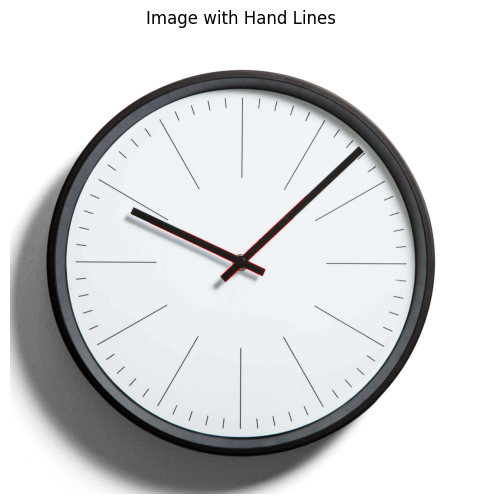

In [184]:
# Create a copy of the original image to draw hand lines
img_with_hand_lines = img.copy()

# Check if any lines were detected
if lines is not None:
    # Draw the hand lines near the center
    for line in lines:
        for x1, y1, x2, y2 in line:
            if line_near_center(x1, y1, x2, y2, cx, cy, radius):
                cv2.line(img_with_hand_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Convert BGR to RGB for displaying
    img_with_hand_lines_rgb = cv2.cvtColor(img_with_hand_lines, cv2.COLOR_BGR2RGB)
    
    # Display the image with hand lines
    plt.figure(figsize=(6,6))
    plt.imshow(img_with_hand_lines_rgb)
    plt.title('Image with Hand Lines')
    plt.axis('off')
    plt.show()
else:
    print("No lines were detected to draw hand lines.")


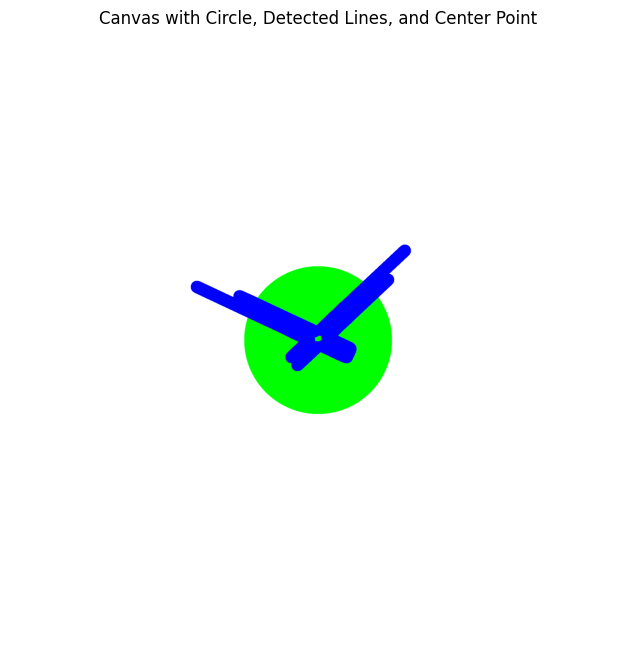

In [187]:
# Create a blank canvas with the same dimensions as the original image
canvas = np.full_like(img, 255)  # White background

# Define the center coordinates and radius
center_coordinates = (int(cx), int(cy))
circle_radius = 300

# Draw the center point on the canvas
center_color = (0, 0, 255)  # Red color in BGR format
center_radius = 5  # Radius of the center point
cv2.circle(canvas, center_coordinates, center_radius, center_color, -1)

# Draw the circle around the center on the canvas
circle_color = (0, 255, 0)  # Green color in BGR format
cv2.circle(canvas, center_coordinates, circle_radius, circle_color, -1)

# Draw the detected lines within the circle on the canvas
# Draw the detected lines with increased thickness on the canvas
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            if line_near_center(x1, y1, x2, y2, cx, cy, radius):
                # Draw thicker lines
                cv2.line(canvas, (x1, y1), (x2, y2), (255, 0, 0), thickness=50)
else:
    print("No lines to draw.")

# Convert BGR to RGB for displaying with matplotlib
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

# Display the canvas
plt.figure(figsize=(8,8))
plt.imshow(canvas_rgb)
plt.title('Canvas with Circle, Detected Lines, and Center Point')
plt.axis('off')
plt.show()
